# Phenolopy

## Initialise phenolopy

### Load packages

In [1]:
%matplotlib inline
%load_ext autoreload

import os, sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import datacube
sys.path.append('../../../Scripts')
from dea_datahandling import load_ard
from dea_dask import create_local_dask_cluster
from dea_plotting import display_map, rgb

sys.path.append('../../modules')
import phenolopy

sys.path.append('../../shared')
import satfetcher, tools

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Set up a dask cluster

In [2]:
# initialise the cluster. paste url into dask panel for more info
create_local_dask_cluster()

# open up a datacube connection
dc = datacube.Datacube(app='phenolopy')

Client Scheduler: tcp://127.0.0.1:38135 Dashboard: /user/lewis/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


## Study area and data setup

### Set study area, time range, show map

In [3]:
# testing study area extent - yandi and roy hill
#lat_extent, lon_extent = (-22.82901, -22.67901), (118.94980, 119.29979)  # yandi
lat_extent, lon_extent = (-22.63461, -22.33461), (119.88111, 120.18111) # royhill

# display onto interacrive map
display_map(x=lon_extent, y=lat_extent)

### Load DEA ODC satellite data

In [4]:
# provide study area name
study_area = 'royhill'

# select start and end year range
time_range = ('2016', '2020')

# set datacube query parameters
platform = 'landsat'
bands = ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']
#bands = ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir_1', 'nbart_swir_2'] # sentinel
min_gooddata = 0.90

# fetch satellite data from dea ard product
ds = satfetcher.load_dea_ard(platform=platform, 
                             bands=bands, 
                             x_extent=lon_extent, 
                             y_extent=lat_extent, 
                             time_range=time_range, 
                             min_gooddata=min_gooddata, 
                             use_dask=True)

# display dataset
#ds

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,
/home/jovyan/tenement-tools/notebooks/phenolopy/../../../Tools/dea_tools/datahandling.py:237: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Loading DEA ODC ARD satellite data.
Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 83 out of 227 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Returning 83 time steps as a dask array
Satellite imagery fetched successfully.


### Conform DEA band names

In [5]:
# rename dea bands to common standard
ds = satfetcher.conform_dea_ard_band_names(ds=ds, 
                                           platform=platform)

# display dataset
#ds

Conforming DEA ARD satellite band names.
Satellite band names conformed successfully.


### Calculate vegetation index

In [6]:
# takes our dask ds and calculates veg index from spectral bands
ds = tools.calculate_indices(ds=ds, 
                             index='mavi', 
                             custom_name='veg_idx', 
                             rescale=False, 
                             drop=True)

# display dataset
#ds

Calculating indices: mavi.
Calculating index: mavi
Renamed default indices.
Calculated indices successfully.


## Pre-process vegetation data

### Ensure first/last date are start/end of year

In [7]:
# append jan 1st/31st dec scenes to dataset if missing
ds = phenolopy.conform_edge_dates(ds=ds)

# display dataset
#ds

Conforming edge dates.
First date was not Jan 1st. Prepending dummy.
Last date was not Dec 31st. Appending dummy.
Conformed edge dates successfully.


### Resample dataset into weekly medians

In [8]:
# we need to do weekly first, then group-resample later
ds = phenolopy.resample(ds=ds, 
                        interval='1W',
                        inplace=True)

# display dataset
#ds

Resampling dataset.
Resampled dataset successful.



### Interpolate missing values

In [9]:
# interpolate missing values
ds = phenolopy.interpolate(ds=ds, 
                           method='full', 
                           inplace=True)

# display dataset
#ds

Interpolating empty values in dataset.
Interpolated empty values successfully.


### Group weeks into a year of weekly all-time medians

In [10]:
# take the dataset ds and group and reduce dataset in median weeks (52 for one year)
ds = phenolopy.group(ds=ds, 
                     interval='week',
                     inplace=True)

# display dataset
#ds

Grouping dataset.
Selecting year: 2019 to re-label times after grouping.


/env/lib/python3.6/site-packages/xarray/core/accessor_dt.py:44: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  field_values = getattr(values_as_series.dt, name).values


Grouped dataset successful.


In [11]:
# takes our dask ds and remove outliers from data using median method
ds = phenolopy.remove_outliers(ds=ds, 
                               method='median', 
                               user_factor=2, 
                               z_pval=0.05)

# display dataset
#ds

Removing outliers via method: median
Generated roll window size is: 3
Outlier removal successful.


### Resample dataset into final intervals (weekly, bi-monthly, monthly)

In [12]:
# take dataset and resample data to bi-monthly medians (1SMS)
ds = phenolopy.resample(ds=ds, 
                        interval='1SM',
                        inplace=True)

# display dataset
#ds

Resampling dataset.
Resampled dataset successful.



### Remove first/last time if outside main year

In [13]:
# remove any years outside of dominant year
ds = phenolopy.remove_overshoot_times(ds=ds, max_times=3)

# display dataset
#ds

Removing times that occur in overshoot years.
Detected 2 or more years in dataset. Removing overshoot times.
Dropped 1 times for year 2018.
Removed times that occur in overshoot years successfully.


## Smooth data on per-pixel basis

In [14]:
# use savitsky-golay filter to smooth across time dimension
ds = phenolopy.smooth(ds=ds, 
                      method='savitsky', 
                      window_length=3, 
                      polyorder=1, 
                      sigma=1)

# display dataset
#ds

Smoothing data via method: savitsky.
Smoothing successful.



## Calculate Phenometrics

### Compute into memory

In [15]:
# compute
ds = ds.compute()

# display dataset
#ds

### Calculate phenometrics

In [17]:
# set desired metrics
metrics = ['sos', 'eos', 'lios', 'sios', 'liot', 'siot']

# calc phenometrics via phenolopy!
ds_phenos = phenolopy.calc_phenometrics(ds=ds, 
                                        metric=metrics,
                                        peak_metric='pos', 
                                        base_metric='vos', 
                                        method='seasonal_amplitude', 
                                        factor=0.2, 
                                        thresh_sides='one_sided', 
                                        abs_value=0.1)

Beginning calculation of phenometrics. Please wait.
Beginning calculation of peak of season (pos) values and times.
Calculating peak of season (pos) values.
Calculating peak of season (pos) times.
Success!
Beginning calculation of valley of season (vos) values and times.
Calculating valley of season (vos) values.
Calculating valley of season (vos) times.
Success!
Beginning calculation of middle of season (mos) values (times not possible).
Calculating middle of season (mos) values.
Success!
Beginning calculation of base (bse) values (times not possible).
Calculating base (bse) values.
Success!
Beginning calculation of amplitude of season (aos) values (times not possible).
Calculating amplitude of season (aos) values.
Success!
Beginning calculation of start of season (sos) values and times.
Calculating start of season (sos) values via method: seasonal_amplitude.
Calculating start of season (sos) times via method: seasonal_amplitude.
Success!
Beginning calculation of end of season (eos) v

## Display phenometric

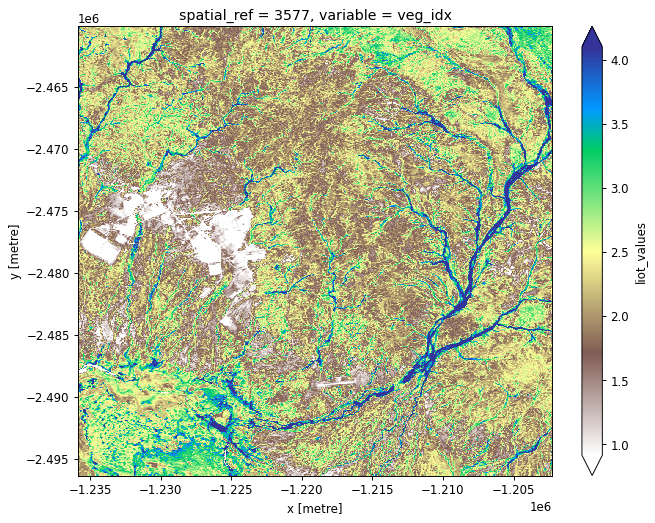

In [20]:
# set the metric you want to view (e.g. pos_values, pos_times, vos_values, vos_times, ect.)
metric_name = 'liot_values'

# create fig
fig = plt.figure(figsize=(9, 7), dpi=85)

# plot this on map
ds_phenos[metric_name].plot(robust=True, cmap='terrain_r')

## Calculate number of seasons (optional)

In [ ]:
# take our dask ds and calculate number of seasons (num of major peaks) per-pixel
ds_nos = phenolopy.calc_num_seasons(ds=ds)

# display dataset
fig = plt.figure(figsize=(7, 7))
ds_nos['nos_values'].plot(robust=True)